<a href="https://colab.research.google.com/github/Bruno-Moreno/Tesis/blob/main/experiments/dpp_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dppy
!pip install umap-learn
!pip install -U pydpp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# DPP NET

In [ ]:
# Import usual libraries
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random

# Import other libaries
import tensorflow as tf
import keras
from keras.models import Sequential , Model
from keras import backend as K
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import BatchNormalization


#Import DPP libraries
from pydpp.dpp import DPP
from sklearn.gaussian_process.kernels import PairwiseKernel

#Functions
from sklearn.metrics import accuracy_score , pairwise_distances
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.model_selection import train_test_split

#Others 
import warnings
warnings.filterwarnings("ignore")

## Train Dataset

In [ ]:
def dataset(name):
  if name == "FASHION_MNIST":

    fashion_mnist = keras.datasets.fashion_mnist
    (X_train_full,y_train_full) , (X_test , y_test) = fashion_mnist.load_data()

    X_val , X_train =  X_train_full[:5000] / 255.0 , X_train_full[5000:] / 255.0
    y_val , y_train =  y_train_full[:5000]  , y_train_full[5000:] 

    print(f'Train Shape: {X_train.shape}')
    print(f'Val Shape: {X_val.shape}')
    print(f'Test Shape: {X_test.shape}')

    return X_train , y_train , X_val, y_val , X_test , y_test

  elif name == "MNIST":

    mnist = keras.datasets.mnist
    (X_train_full,y_train_full) , (X_test , y_test) = mnist.load_data()

    X_val , X_train =  X_train_full[:5000] / 255.0 , X_train_full[5000:] / 255.0
    y_val , y_train =  y_train_full[:5000]  , y_train_full[5000:] 

    print(f'Train Shape: {X_train.shape}')
    print(f'Val Shape: {X_val.shape}')
    print(f'Test Shape: {X_test.shape}')

    return X_train , y_train , X_val, y_val , X_test , y_test

  else: 
    print("Error")

X_train , y_train , X_val, y_val , X_test , y_test = dataset("FASHION_MNIST")

Train Shape: (55000, 28, 28)
Val Shape: (5000, 28, 28)
Test Shape: (10000, 28, 28)


In [ ]:
def get_samples_train(X, y , clase):
  data = pd.DataFrame(X.reshape((len(X), 28*28)))
  data["y"] = y
  if clase < 4:
    samples = data.loc[data.y == clase, :].sample(2500, random_state = 666)
  elif clase < 7:
    samples = data.loc[data.y == clase, :].sample(1500, random_state = 666)
  else:
    samples = data.loc[data.y == clase, :].sample(500, random_state = 666)

  return list(samples.index)

In [ ]:
samples_list = []
for i in range(10):
  samples_list += get_samples_train(X_train, y_train, i)
  
train = pd.DataFrame(X_train.reshape((len(X_train), 28*28)))
train_modified = train.loc[samples_list, :]
train_modified

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
3108,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.533333,0.517647,0.654902,0.000000,0.00000,0.007843,0.000000,0.000000,0.000000,0.0
13300,0.0,0.0,0.0,0.000000,0.0,0.003922,0.0,0.0,0.0,0.000000,...,0.352941,0.313725,0.372549,0.000000,0.00000,0.007843,0.000000,0.000000,0.000000,0.0
42129,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.364706,...,0.447059,0.533333,0.603922,0.329412,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
47737,0.0,0.0,0.0,0.007843,0.0,0.000000,0.0,0.0,0.0,0.070588,...,0.796078,0.815686,0.505882,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
47188,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.027451,...,0.070588,0.023529,0.070588,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28327,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
2998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
42961,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
18168,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.003922,...,0.000000,0.003922,0.000000,0.458824,0.72549,0.662745,0.607843,0.584314,0.164706,0.0


In [ ]:
X_train = train_modified.to_numpy().reshape((-1,28,28))
y_train = y_train[samples_list]
X_train.shape

(16000, 28, 28)

In [ ]:
def get_samples_val(X, y , clase):
  data = pd.DataFrame(X.reshape((len(X), 28*28)))
  data["y"] = y
  if clase < 4:
    samples = data.loc[data.y == clase, :].sample(250, random_state = 666)
  elif clase < 7:
    samples = data.loc[data.y == clase, :].sample(150, random_state = 666)
  else:
    samples = data.loc[data.y == clase, :].sample(50, random_state = 666)

  return list(samples.index)

lista = get_samples_val(X_val, y_val, 8)

In [ ]:
samples_list = []
for i in range(10):
  samples_list += get_samples_val(X_val, y_val, i)
  
val = pd.DataFrame(X_val.reshape((len(X_val), 28*28)))
val_modified = val.loc[samples_list, :]
val_modified

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
3050,0.0,0.0,0.0,0.0,0.000000,0.0,0.003922,0.0,0.000000,0.000000,...,0.709804,0.725490,0.800000,0.227451,0.000000,0.007843,0.000000,0.000000,0.0,0.0
4407,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.156863,0.129412,0.066667,0.011765,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2307,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.466667,...,0.364706,0.337255,0.258824,0.109804,0.000000,0.000000,0.000000,0.000000,0.0,0.0
791,0.0,0.0,0.0,0.0,0.000000,0.0,0.003922,0.0,0.019608,0.207843,...,0.615686,0.603922,0.313725,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3865,0.0,0.0,0.0,0.0,0.003922,0.0,0.000000,0.0,0.000000,0.160784,...,0.643137,0.694118,0.639216,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4490,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4827,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3096,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.027451,0.592157,0.517647,0.462745,0.447059,0.458824,0.192157,0.0,0.0
932,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [ ]:
X_val = val_modified.to_numpy().reshape((-1,28,28))
y_val = y_val[samples_list]
X_val.shape

(1600, 28, 28)

## AutoEncoder

In [ ]:
def encoder_model(latent_size):
  encoder = Sequential(name = "encoder")

  #Encoder
  encoder.add(Flatten(input_shape = [28 , 28]))
  encoder.add(Dense(500, activation = "sigmoid"))
  encoder.add(Dense(300, activation = "sigmoid"))
  encoder.add(Dense(100, activation = "sigmoid"))
  encoder.add(Dense(latent_size, activation = "tanh"))

  #Decoder 
  print(encoder.summary())
  return encoder 

def decoder_model(latent_size):
  decoder = Sequential(name = "decoder")

  #Decoder 
  decoder.add(Dense(100, input_shape = (latent_size , ) , activation = "sigmoid"))
  decoder.add(Dense(300, activation = "sigmoid"))
  decoder.add(Dense(500, activation = "sigmoid"))
  decoder.add(Dense(784, activation = "sigmoid"))
  decoder.add(Reshape(target_shape = (28,28)))
  
  return decoder 

## Baseline

In [ ]:
def FFNN(latent_size):
  model = Sequential(name='FFNN')
  model.add(Dense(10 , input_shape = (latent_size , ) ,  activation = "softmax" , kernel_initializer='random_normal'))
  model.summary()

  return model

def CNN_deep(shape):
  model = Sequential(name = 'CNN')
  model.add(Dense(784 , input_shape = (latent_size , ) ,  activation = "softmax" , kernel_initializer='random_normal'))
  model.add(Reshape((28,28,-1)))
  model.add(Conv2D(32, (3, 3), padding= "same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(64, padding='same',  kernel_size=(3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.summary()

  return model 

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
class mini_batch_sampling(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=128, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.on_epoch_end()

  def __len__(self):
    return len(self.key_array)//self.batch_size

  def __getitem__(self, index):
    keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
    x = np.asarray(self.images[keys], dtype=np.float32)
    y = np.asarray(self.labels[keys], dtype=np.float32)
    return x, y

  def on_epoch_end(self):
    if self.shuffle:
      self.key_array = np.random.permutation(self.key_array)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_32 (Dense)            (None, 500)               392500    
                                                                 
 dense_33 (Dense)            (None, 300)               150300    
                                                                 
 dense_34 (Dense)            (None, 100)               30100     
                                                                 
 dense_35 (Dense)            (None, 32)                3232      
                                                                 
Total params: 576,132
Trainable params: 576,132
Non-trainable params: 0
_________________________________________________________________
None
Model: "FFNN"
__________________________________

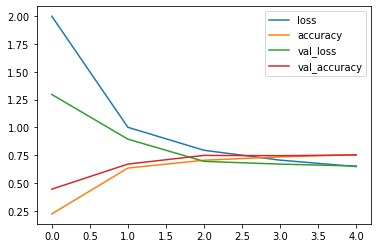

In [ ]:
#Creating the models 
latent_size = 32
batch_size = 64
epochs = 15

#Model
encoder = encoder_model(latent_size)
FC = FFNN(latent_size)
FC = CNN_deep(latent_size)

#Joining the models 
img = Input(shape = (28, 28))
latent_vector = encoder(img)
output = FC(latent_vector)
model = Model(inputs = img, outputs = output)

#Generator
generator_uniform = mini_batch_sampling(images= X_train, labels= y_train, batch_size = batch_size, shuffle=True)

#Compile
model.compile("adam", loss = ['sparse_categorical_crossentropy'] , metrics = ["accuracy"])

#Fit
time_callback = TimeHistory()

history = model.fit_generator(generator_uniform, epochs=epochs, 
                    validation_data = (X_val, y_val), verbose=1, callbacks = [time_callback])

print(time_callback.times)
pd.DataFrame(history.history).plot()

## Dual Net

In [ ]:
class DPP_RBF_Fast_Autoencoder(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size = 128, N = 100, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.N = N
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.embedded_image = encoder.predict(images)
    self.on_epoch_end()


  def __len__(self):
    return len(self.key_array)//self.N 

  def __getitem__(self, index):
    #keys = self.key_array[index*self.N:(index+1)*self.N]
    print(f'Key Array Shape: {len(self.key_array)}')
    if len(self.key_array) > self.N:
      random_keys = np.random.choice(self.key_array , self.N , replace = False)
    else:
      random_keys = self.key_array

    tmp_x = self.images[random_keys]
    tmp_y = self.labels[random_keys]

    #From the Autoencoder 
    tmp_x_embedded = self.embedded_image[random_keys]

    dpp = DPP(tmp_x_embedded)
    dpp.compute_kernel(kernel_type = "rbf" , sigma = 15) 

    try:
      
      keys_DPP = dpp.sample_k(self.batch_size)

    except:

      dpp = DPP(tmp_x_embedded)
      dpp.compute_kernel(kernel_type = "rbf" , sigma = 10)
      keys_DPP = dpp.sample_k(self.batch_size)

    x, y = self.__data_generation(tmp_x , tmp_y , keys_DPP)

    #self.key_array = np.delete(self.key_array , keys_DPP)
    self.key_array = self.key_array[~np.isin(self.key_array, random_keys)]

    return x , y

  def on_epoch_end(self):
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)

    print(f'Recalculando Representación')

    self.embedded_image = encoder.predict(self.images)

    index = np.array([8 , 666])
    example = X_test[index]
    label = y_test[index]
    y_ = decoder.predict(encoder.predict(example))

    fig, axs = plt.subplots(2, 2, figsize=(8,8))
            
    for i in range(2):
      axs[0, i].imshow(example[i], cmap = "gray")
      axs[0, i].set_xlabel(f'Real {label[i]}')
      axs[1, i].imshow(y_[i], cmap = "gray")
      axs[1, i].set_xlabel(f"Prediction {np.argmax(y_[0], axis=-1)[i]}")

  def __data_generation(self, tmp_x , tmp_y , keys_DPP):

      x = np.asarray(tmp_x[keys_DPP], dtype=np.float32)
      y = np.asarray(tmp_y[keys_DPP], dtype=np.float32)

      return x, (y , x) 

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_40 (Dense)            (None, 500)               392500    
                                                                 
 dense_41 (Dense)            (None, 300)               150300    
                                                                 
 dense_42 (Dense)            (None, 100)               30100     
                                                                 
 dense_43 (Dense)            (None, 64)                6464      
                                                                 
Total params: 579,364
Trainable params: 579,364
Non-trainable params: 0
_________________________________________________________________
None
Model: "FFNN"
__________________________________

Epoch 1/15
Key Array Shape: 15600
Key Array Shape: 15200
      1/Unknown - 2s 2s/step - loss: 1.2372 - CNN_loss: 2.3026 - decoder_loss: 0.7045 - CNN_accuracy: 0.1250 - decoder_accuracy: 0.0564Key Array Shape: 14800
      2/Unknown - 2s 436ms/step - loss: 1.2175 - CNN_loss: 2.3015 - decoder_loss: 0.6755 - CNN_accuracy: 0.1406 - decoder_accuracy: 0.0536Key Array Shape: 14400
      3/Unknown - 3s 464ms/step - loss: 1.2009 - CNN_loss: 2.2989 - decoder_loss: 0.6519 - CNN_accuracy: 0.1615 - decoder_accuracy: 0.0515Key Array Shape: 14000
      4/Unknown - 3s 446ms/step - loss: 1.1900 - CNN_loss: 2.2972 - decoder_loss: 0.6365 - CNN_accuracy: 0.1523 - decoder_accuracy: 0.0508Key Array Shape: 13600
      5/Unknown - 4s 442ms/step - loss: 1.1798 - CNN_loss: 2.2947 - decoder_loss: 0.6223 - CNN_accuracy: 0.1594 - decoder_accuracy: 0.0504Key Array Shape: 13200
      6/Unknown - 4s 447ms/step - loss: 1.1687 - CNN_loss: 2.2889 - decoder_loss: 0.6085 - CNN_accuracy: 0.1641 - decoder_accuracy: 0.0497Key

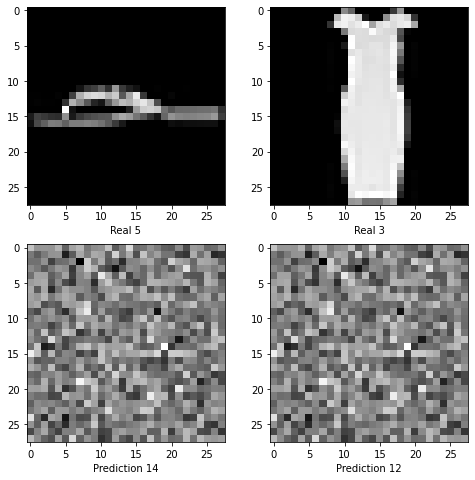

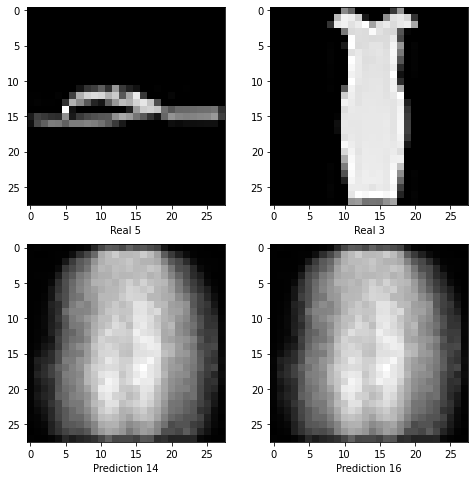

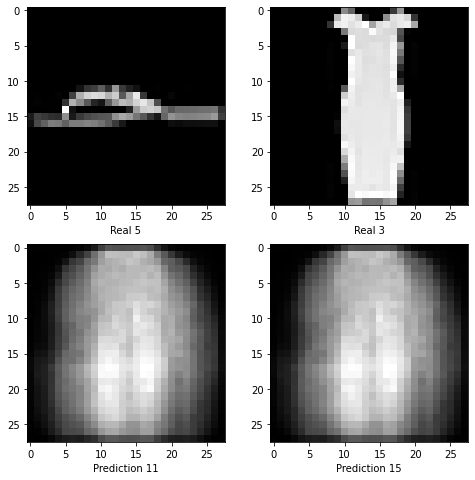

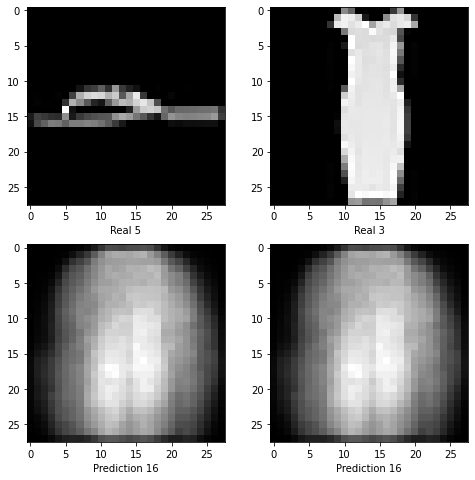

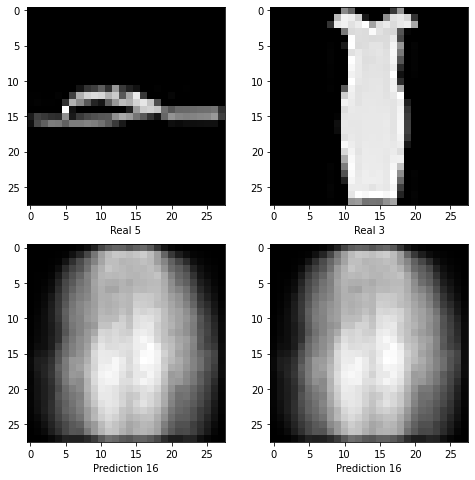

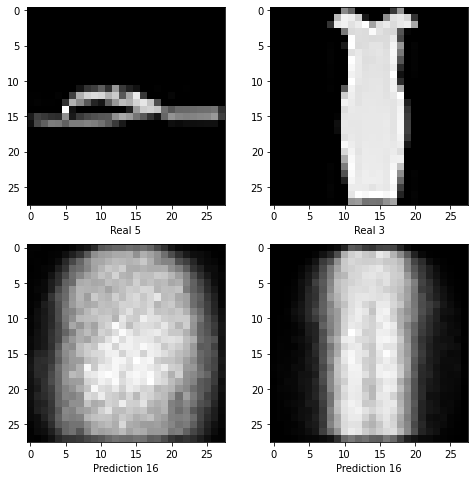

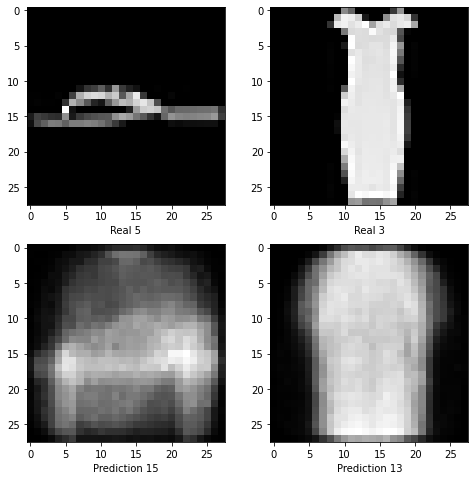

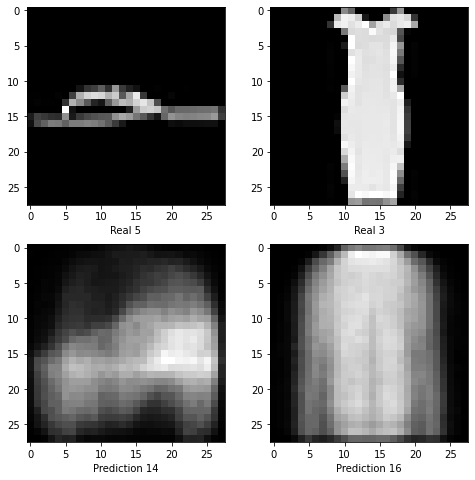

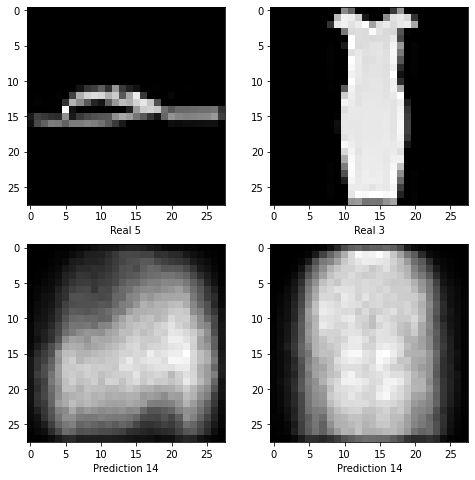

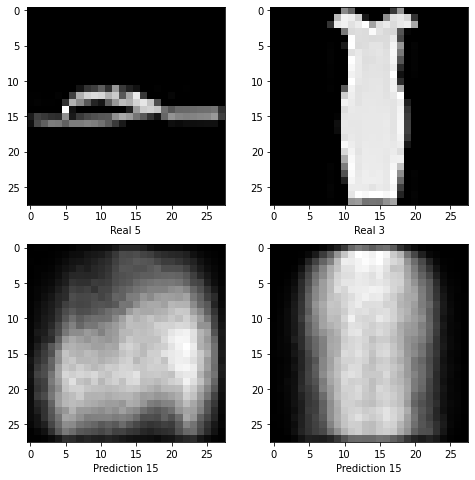

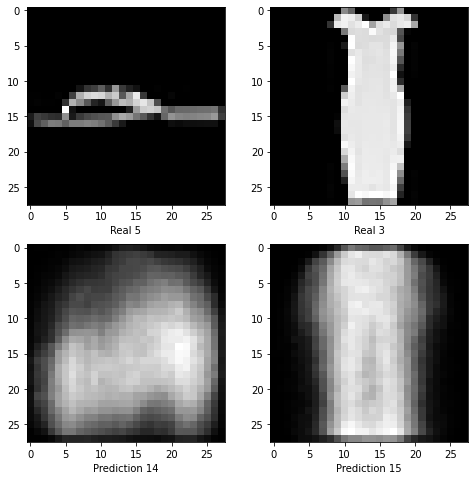

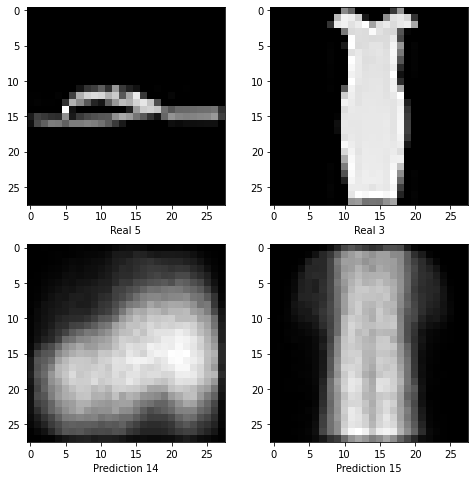

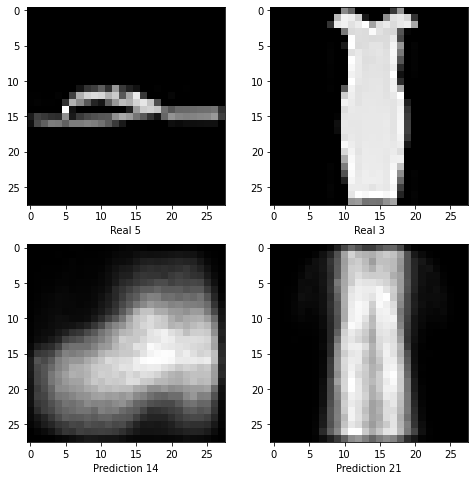

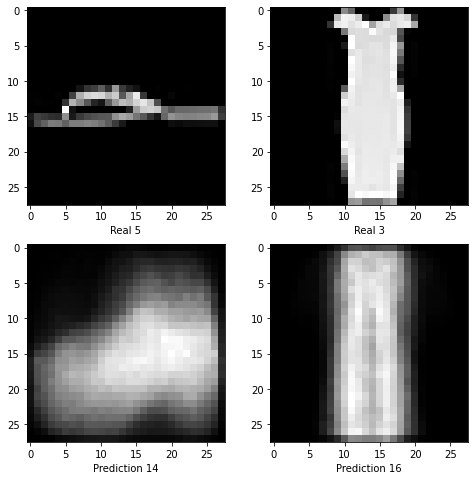

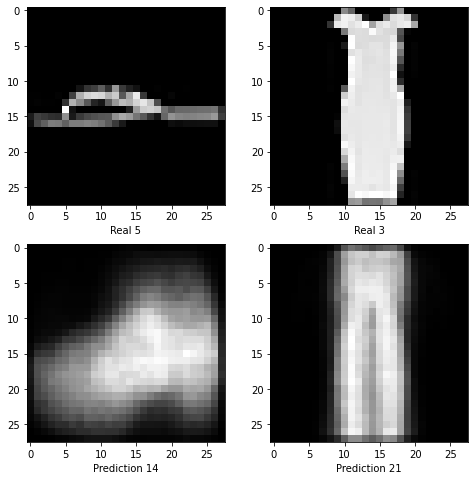

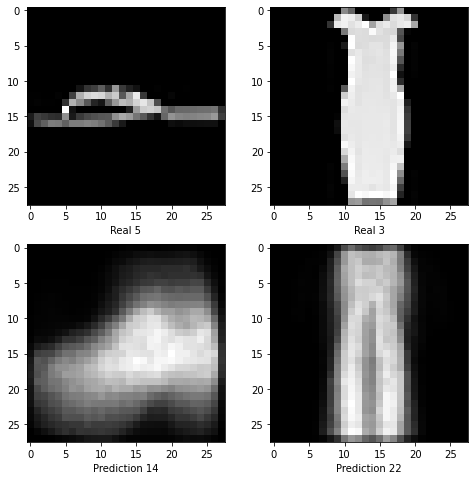

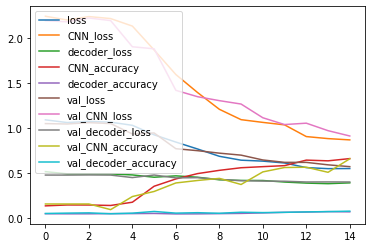

In [ ]:
#Parameters
latent_size = 64
batch_size = 64
epochs = 15
alpha = 1/3

#Models
encoder = encoder_model(latent_size)
decoder = decoder_model(latent_size)
FC = FFNN(latent_size)
FC = CNN_deep(latent_size)

#Joining the models 
img = Input(shape = (28, 28))
latent_vector = encoder(img)
output_FC = FC(latent_vector)
output_decoder = decoder(latent_vector)
model = Model(inputs = img, outputs = [output_FC , output_decoder])
generator_DPP_dual = DPP_RBF_Fast_Autoencoder(images = X_train, labels=y_train,
                        batch_size=batch_size, N = 400, shuffle=False)

model.compile("adam", loss = ['sparse_categorical_crossentropy' , 'binary_crossentropy'] , metrics = ["accuracy"] , loss_weights=[alpha, 1-alpha])

time_callback = TimeHistory()

history = model.fit_generator(generator_DPP_dual, epochs=epochs, steps_per_epoch =-1,
                    validation_data=(X_val, (y_val , X_val)), verbose=1, callbacks = [time_callback])

pd.DataFrame(history.history).plot()

In [ ]:
pd.DataFrame(history.history)

,loss,CNN_loss,decoder_loss,CNN_accuracy,decoder_accuracy,val_loss,val_CNN_loss,val_decoder_loss,val_CNN_accuracy,val_decoder_accuracy
0,1.089137,2.237617,0.514898,0.135417,0.048177,1.047448,2.188577,0.476884,0.156250,0.051094
1,1.059102,2.196194,0.490556,0.145433,0.047147,1.043026,2.175851,0.476613,0.156250,0.055000
2,1.071700,2.234067,0.490516,0.145032,0.047447,1.058172,2.218102,0.478207,0.156250,0.057946
3,1.063544,2.211849,0.489392,0.139824,0.049265,1.047632,2.189559,0.476668,0.093750,0.048058
4,1.028378,2.128359,0.478388,0.175881,0.049622,0.932448,1.899197,0.449073,0.238750,0.054710
5,0.923080,1.863518,0.452862,0.352965,0.051468,0.943775,1.876715,0.477305,0.295000,0.073482
6,0.842556,1.591410,0.468129,0.433894,0.046160,0.769114,1.416249,0.445546,0.389375,0.055000
7,0.765754,1.391432,0.452916,0.493189,0.046803,0.747253,1.345624,0.448068,0.416875,0.059799
8,0.684993,1.206094,0.424442,0.529247,0.049265,0.719799,1.301973,0.428712,0.440000,0.053348
9,0.641871,1.091125,0.417244,0.558093,0.051797,0.697811,1.264208,0.414613,0.372500,0.064844


In [ ]:
time_callback.times

[19.342448234558105,
 18.339659690856934,
 17.903008699417114,
 17.73503589630127,
 17.583473205566406,
 20.033546924591064,
 21.047664403915405,
 21.690178394317627,
 19.249863147735596,
 19.800700902938843,
 20.110074996948242,
 19.12065839767456,
 19.16102933883667,
 19.226215362548828,
 19.20500683784485]

,CNN_loss,CNN_accuracy,val_CNN_loss,val_CNN_accuracy,time,epoch,method,loss,decoder_loss,decoder_accuracy,val_loss,val_decoder_loss,val_decoder_accuracy
0,1.774209,0.302625,1.065014,0.546250,23.942486,1,baseline,NaN,NaN,NaN,NaN,NaN,NaN
1,0.954327,0.650563,0.829098,0.693125,46.436346,2,baseline,NaN,NaN,NaN,NaN,NaN,NaN
2,0.776083,0.719875,0.671233,0.759375,69.049302,3,baseline,NaN,NaN,NaN,NaN,NaN,NaN
3,0.686801,0.754062,0.644651,0.769375,92.602015,4,baseline,NaN,NaN,NaN,NaN,NaN,NaN
4,0.623951,0.776125,0.609626,0.775625,115.450781,5,baseline,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,0.982343,0.644231,1.032516,0.640625,204.831993,11,DPP NET,0.582823,0.383062,0.065376,0.602161,0.386984,0.083571
11,0.909569,0.666667,0.866754,0.695625,224.401361,12,DPP NET,0.553560,0.375556,0.071028,0.547042,0.387185,0.086540
12,0.820352,0.702324,0.851503,0.699375,243.233289,13,DPP NET,0.522029,0.372868,0.068781,0.540429,0.384892,0.087991
13,0.834303,0.704327,0.828937,0.693750,261.896221,14,DPP NET,0.523686,0.368377,0.071099,0.527090,0.376166,0.076205


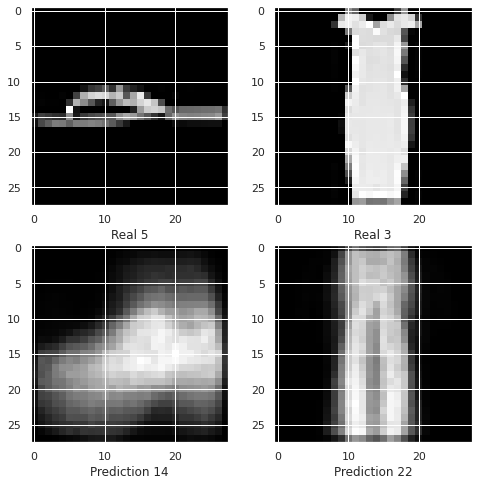

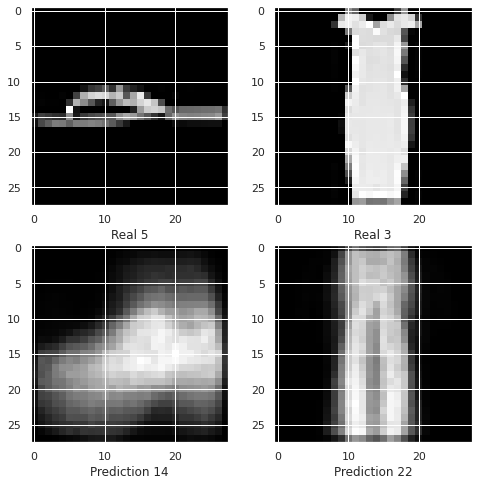

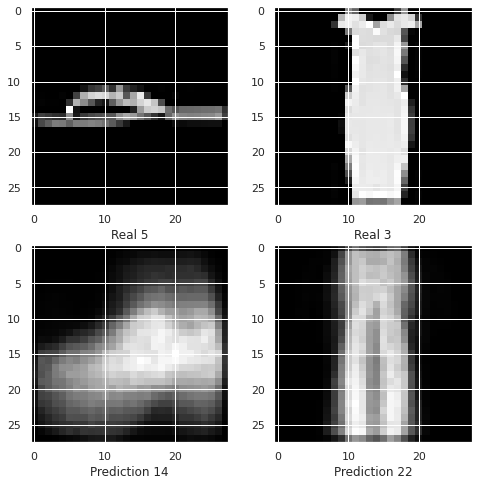

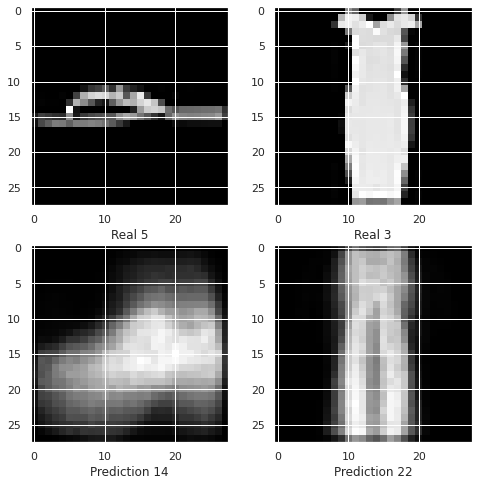

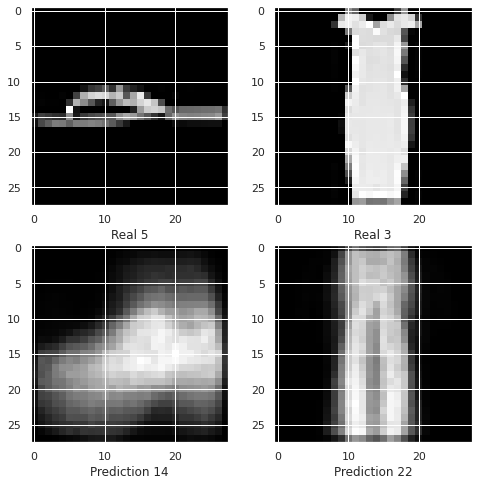

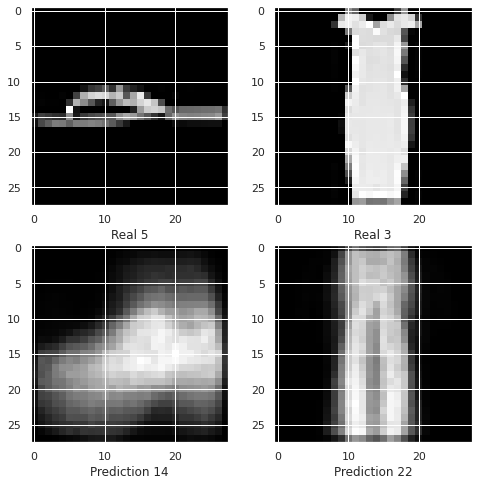

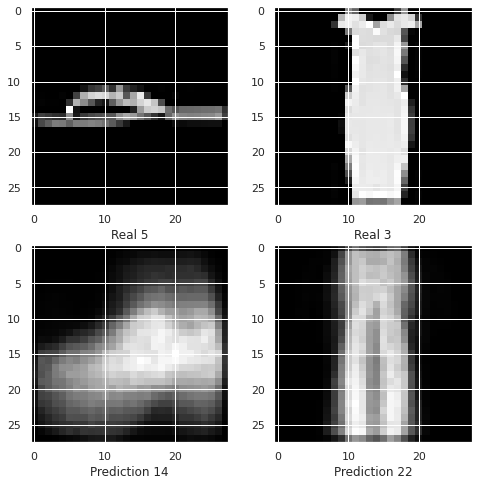

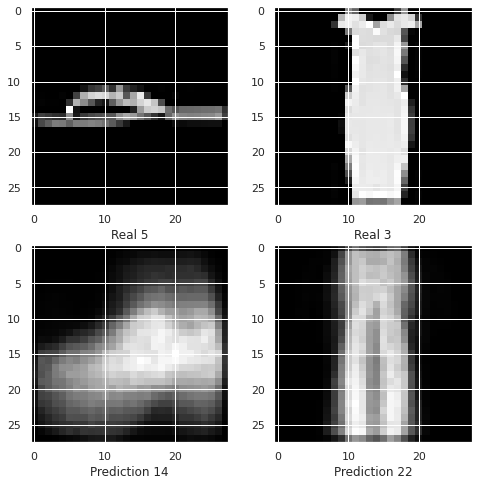

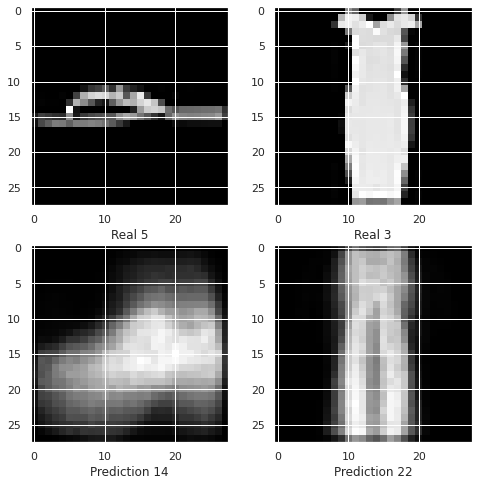

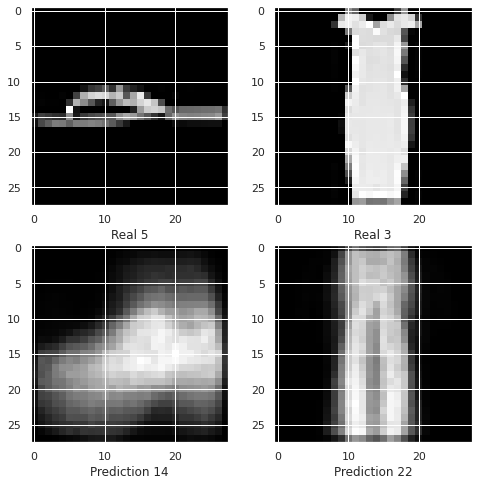

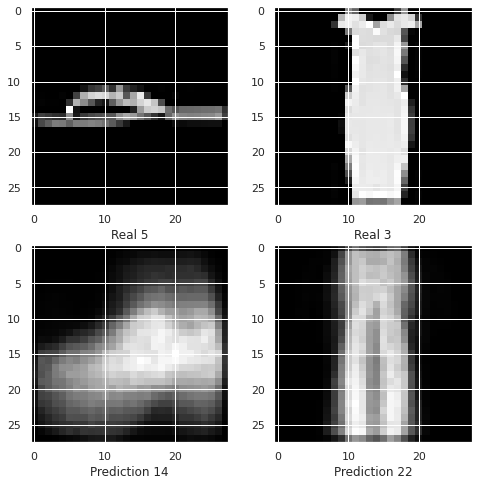

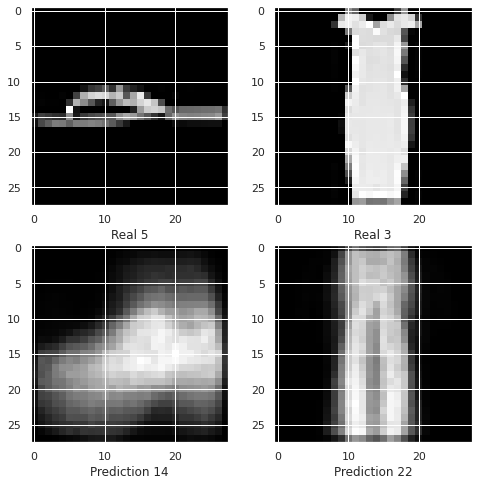

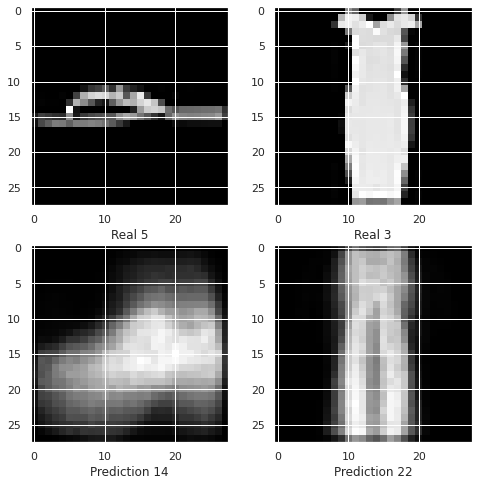

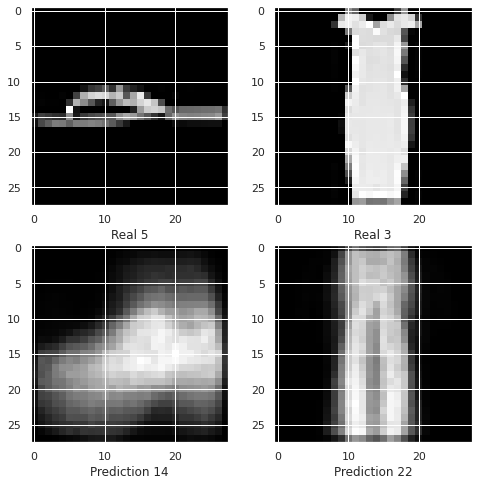

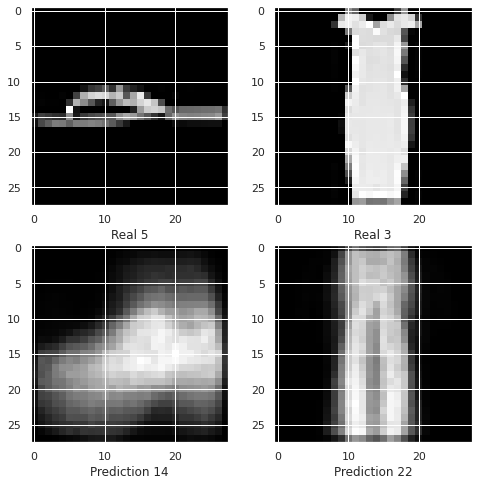

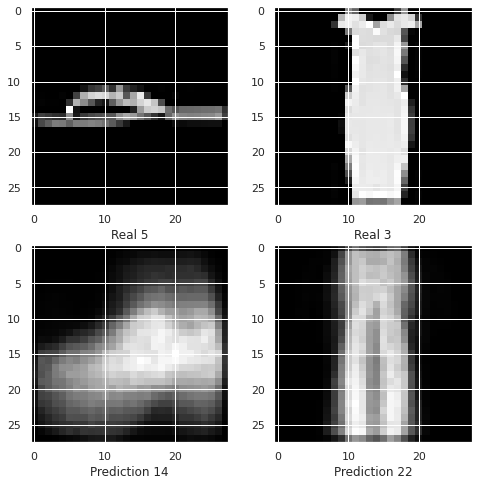

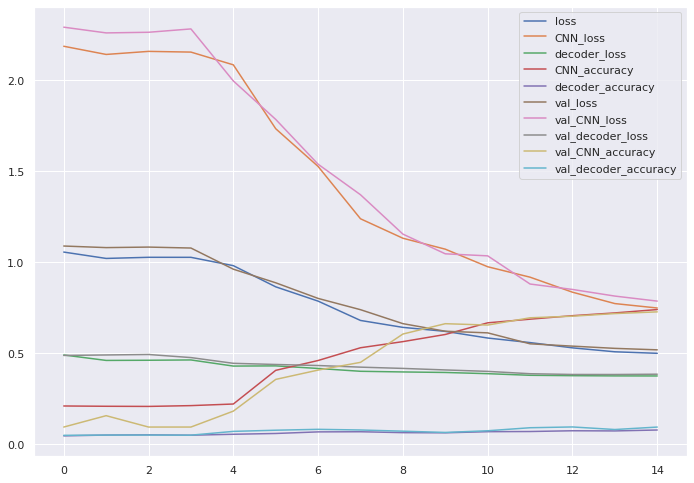

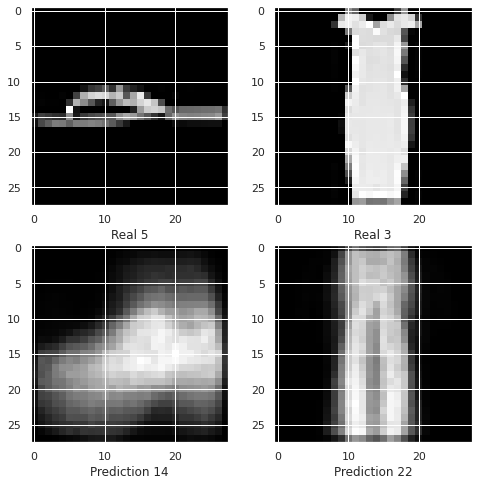

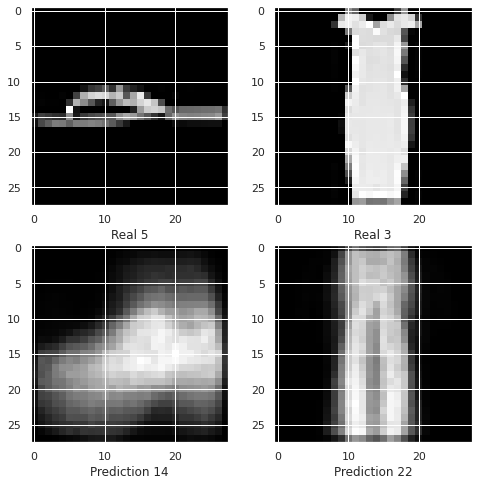

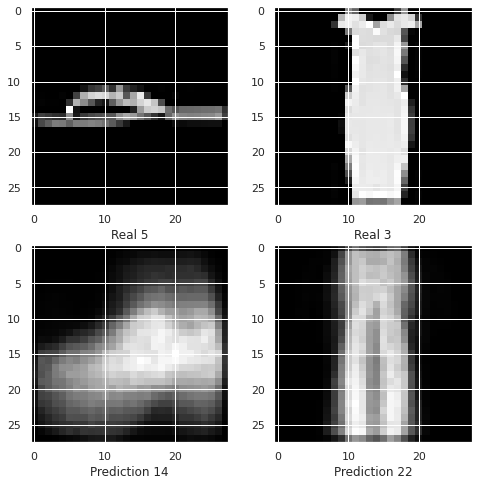

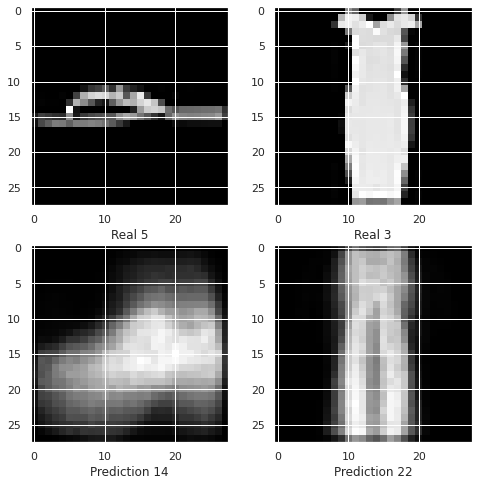

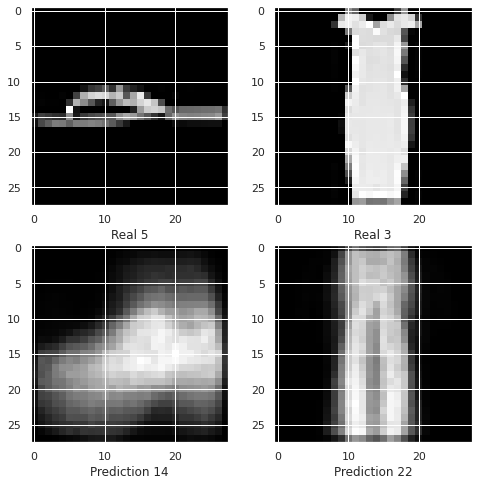

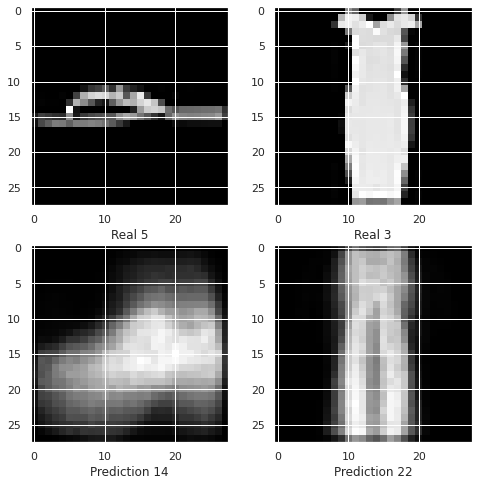

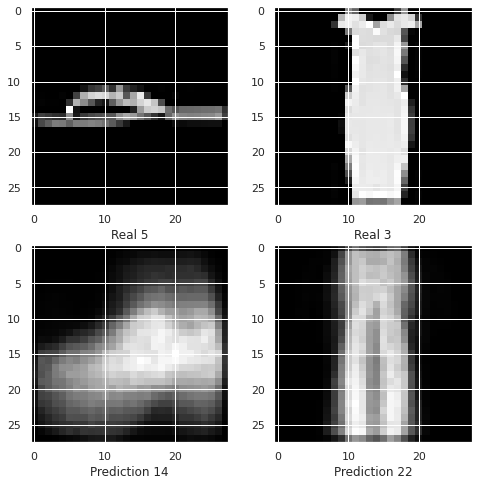

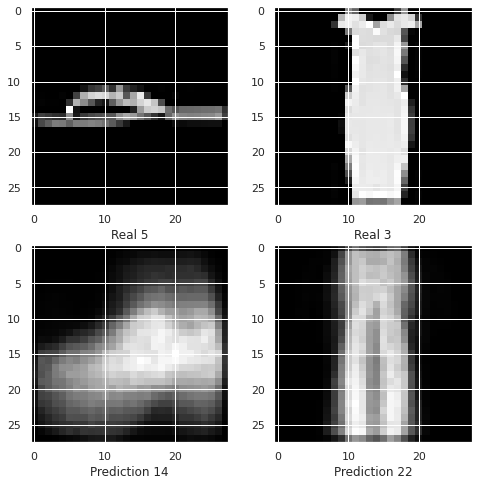

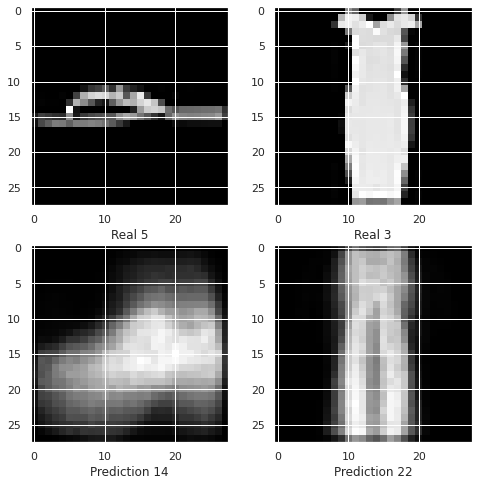

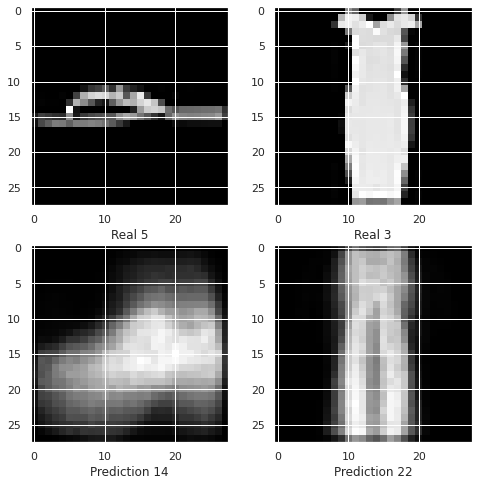

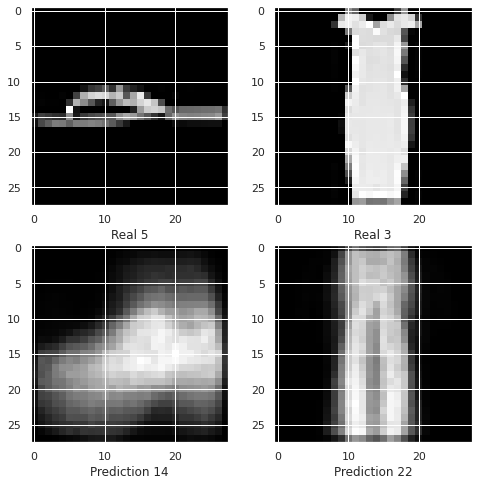

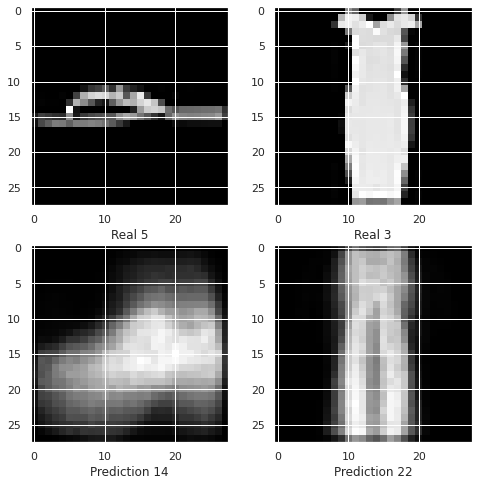

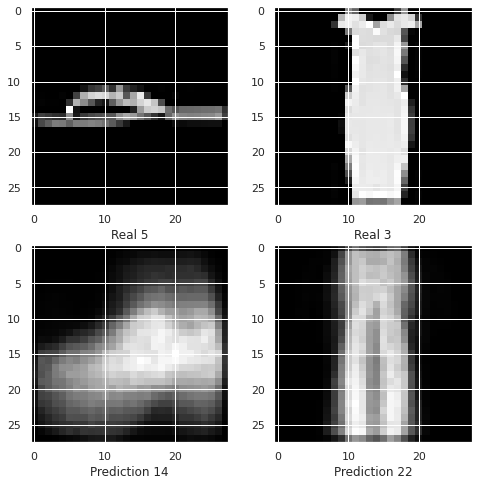

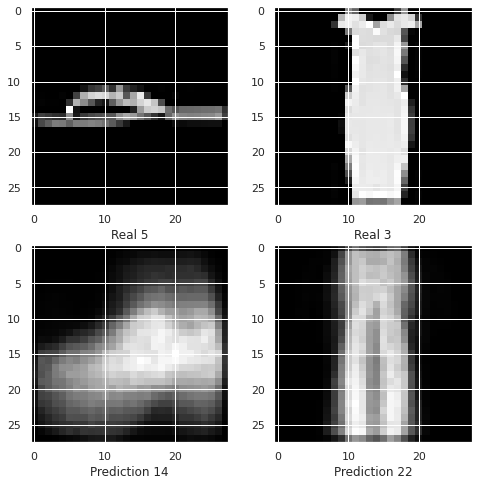

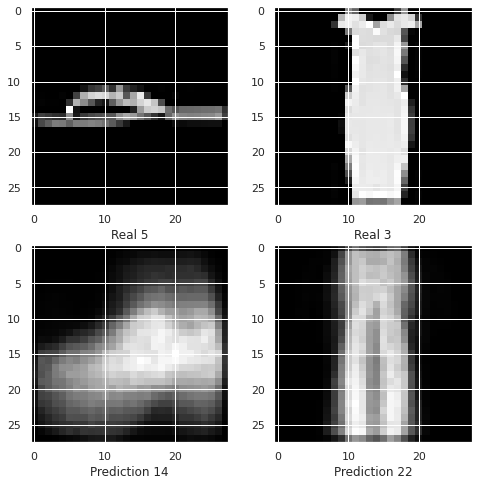

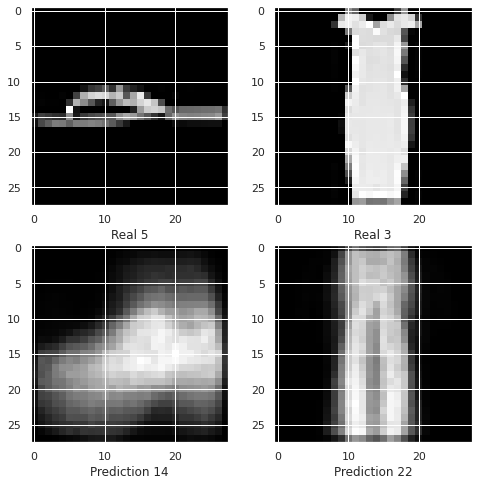

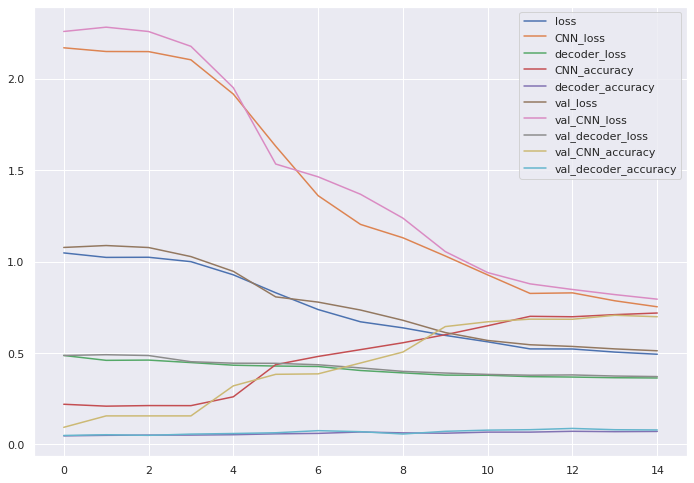

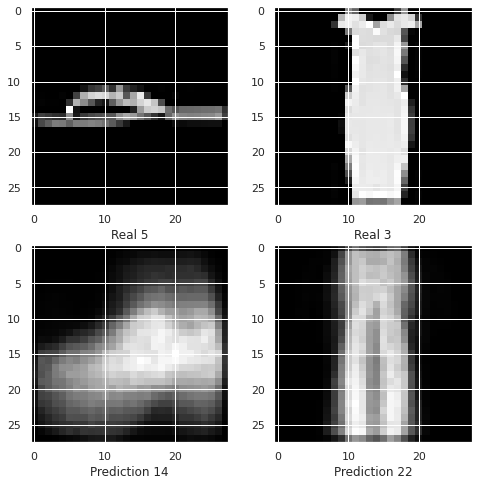

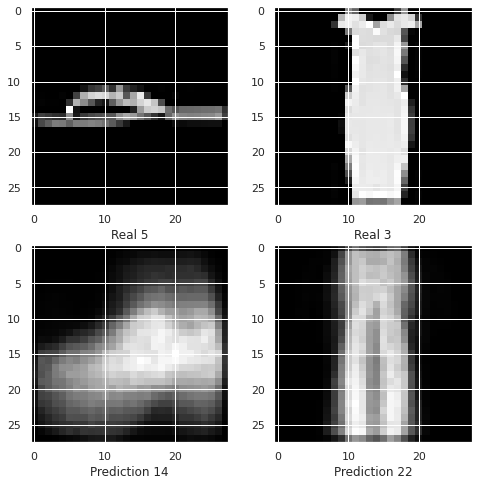

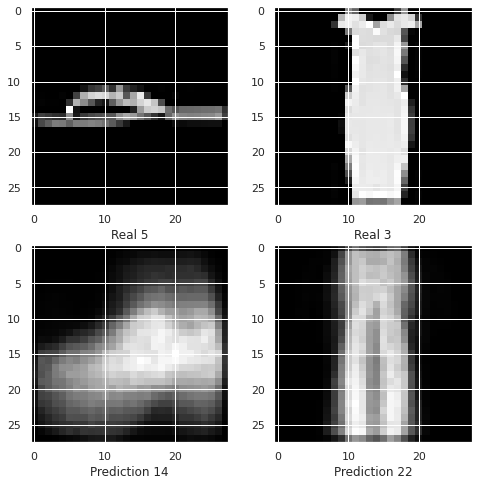

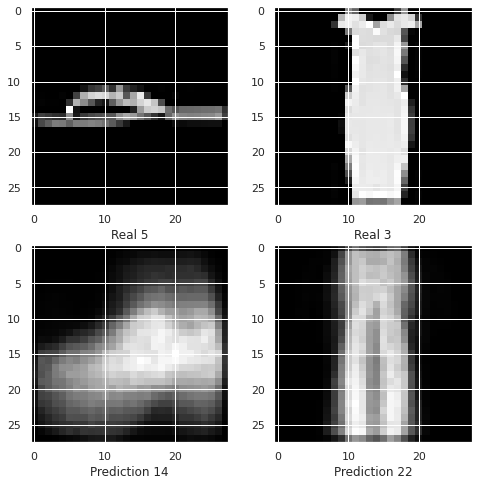

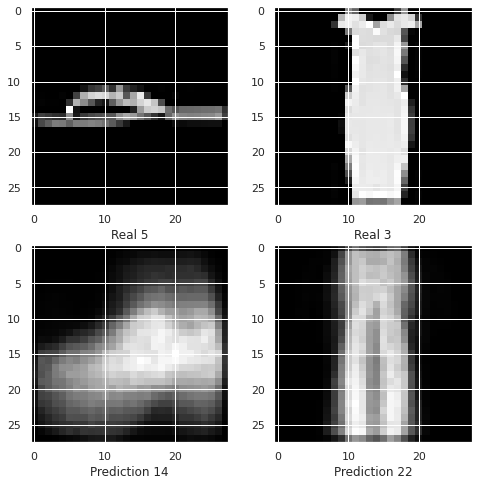

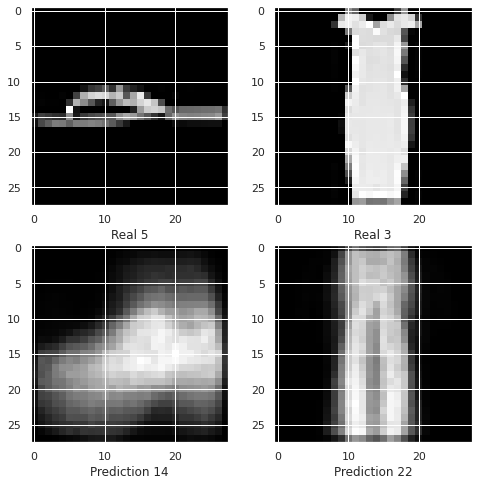

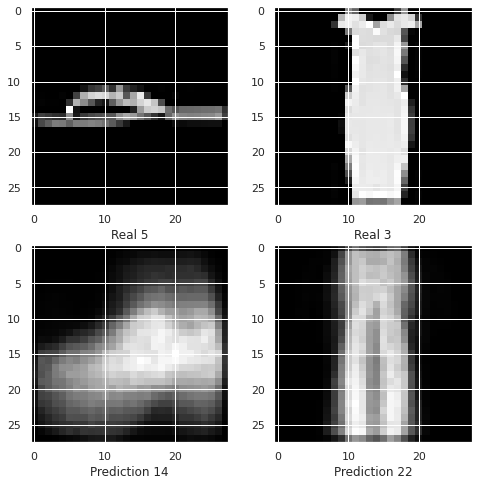

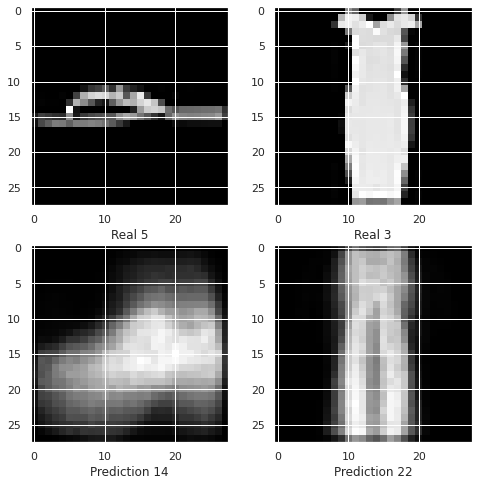

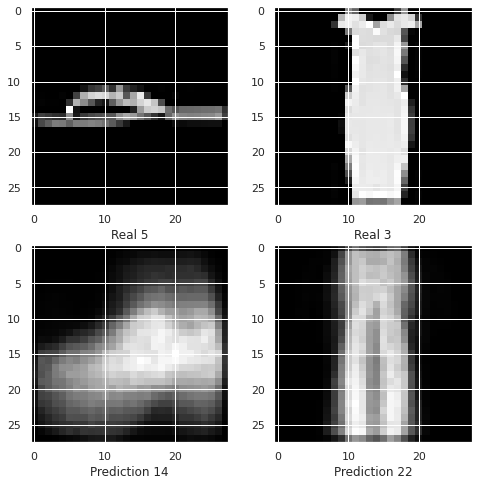

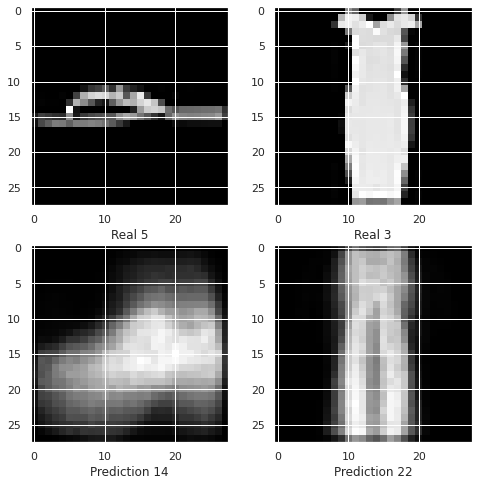

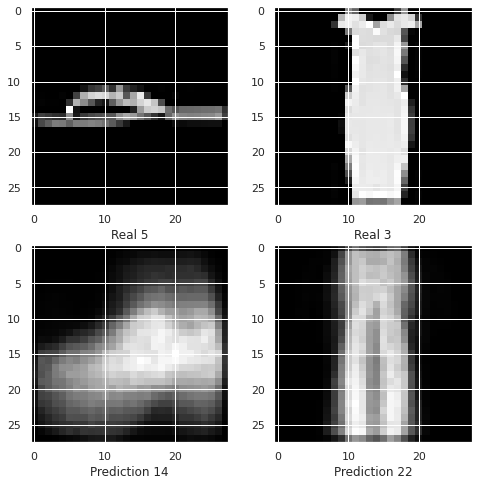

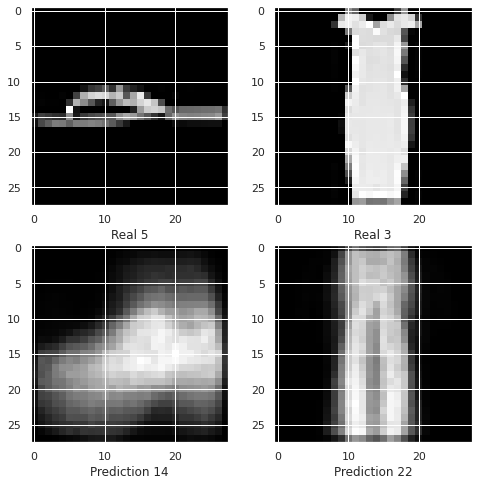

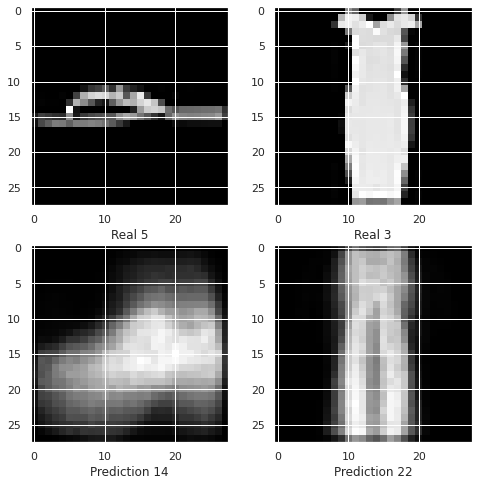

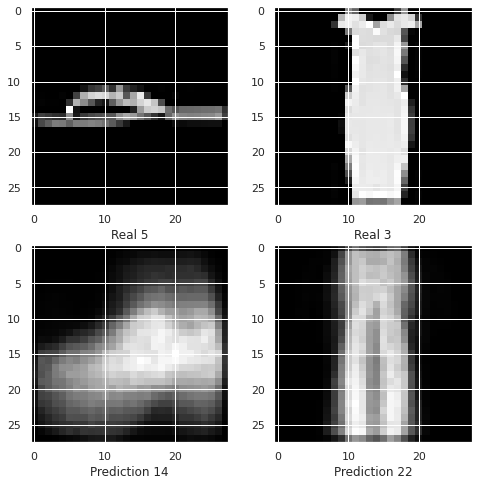

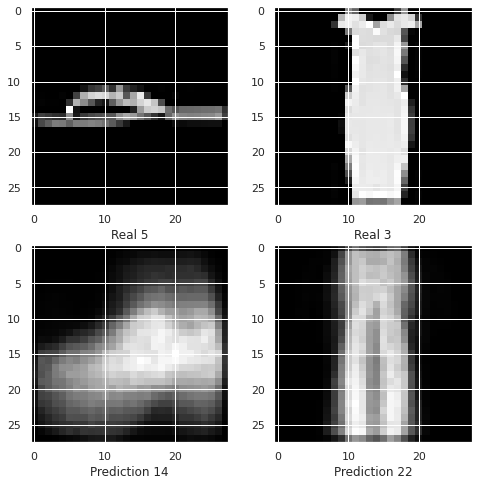

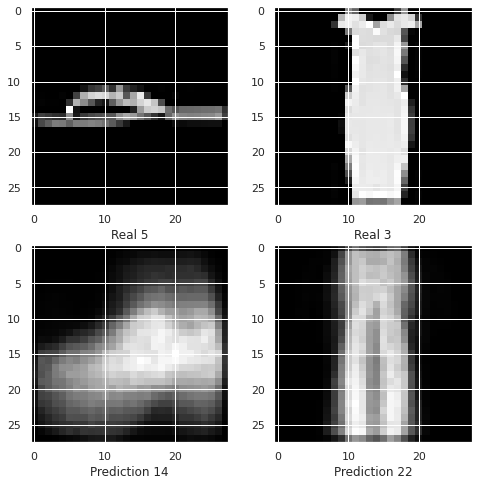

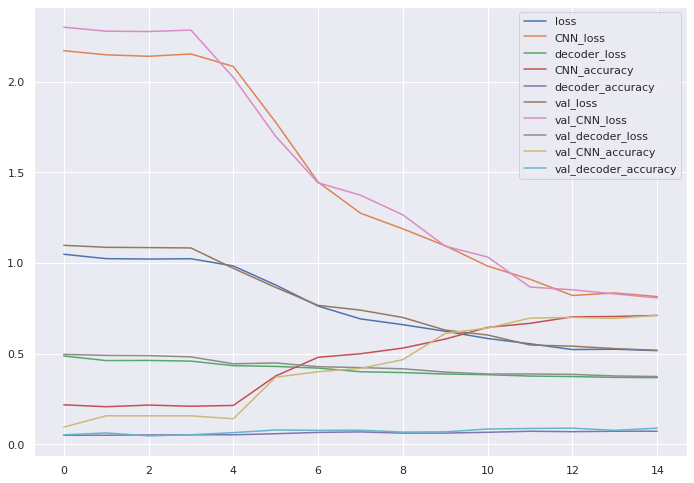

In [ ]:
from IPython.display import display, clear_output

def cum_sum(time_list):
  cumtime = time_list[0]
  cumsum = [cumtime]
  for time in time_list[1:]:
    cumtime += time
    cumsum.append(cumtime)

  return cumsum

def plot_confidence(n):

  #Creating the models 
  epochs = 15
  batch_size = 64
  latent_size = 64
  shape = (28,28,1)
  historial = pd.DataFrame()
  
  for i in range(n):
    
    print(f'Iteration: {i}')

    #####################
    #Baseline
    #####################
    
    #Creating the models 

    #Model
    encoder = encoder_model(latent_size)
    #FC = FFNN(latent_size)
    FC = CNN_deep(latent_size)

    #Joining the models 
    img = Input(shape = (28, 28))
    latent_vector = encoder(img)
    output = FC(latent_vector)
    model = Model(inputs = img, outputs = output)

    #Generator
    generator_uniform = mini_batch_sampling(images= X_train, labels= y_train, batch_size = batch_size, shuffle=True)

    #Compile
    model.compile("adam", loss = ['sparse_categorical_crossentropy'] , metrics = ["accuracy"])

    #Fit
    time_callback = TimeHistory()

    history = model.fit_generator(generator_uniform, epochs=epochs, 
                        validation_data = (X_val, y_val), verbose=1, callbacks = [time_callback])

    loss = pd.DataFrame(history.history)
    loss["time"] =  np.array(time_callback.times).cumsum()
    loss["epoch"] = list(range(1,epochs+1))
    loss["method"] = "baseline"
    loss.rename(columns = {"loss": "CNN_loss", "accuracy": "CNN_accuracy", "val_loss": "val_CNN_loss", "val_accuracy": "val_CNN_accuracy"}, inplace = True)
    historial = pd.concat([historial , loss], axis = 0)

    clear_output(wait=True)

    #####################
    #DPP Net
    #####################

    #Parameters
    latent_size = 64
  
    alpha = 1/3

    #Models
    encoder = encoder_model(latent_size)
    decoder = decoder_model(latent_size)
    #FC = FFNN(latent_size)
    FC = CNN_deep(latent_size)

    #Joining the models 
    img = Input(shape = (28, 28))
    latent_vector = encoder(img)
    output_FC = FC(latent_vector)
    output_decoder = decoder(latent_vector)
    model = Model(inputs = img, outputs = [output_FC , output_decoder])
    generator_DPP_dual = DPP_RBF_Fast_Autoencoder(images = X_train, labels=y_train,
                            batch_size=batch_size, N = 400, shuffle=False)

    model.compile("adam", loss = ['sparse_categorical_crossentropy' , 'binary_crossentropy'] , metrics = ["accuracy"] , loss_weights=[alpha, 1-alpha])

    time_callback = TimeHistory()

    history = model.fit_generator(generator_DPP_dual, epochs=epochs, steps_per_epoch =-1,
                        validation_data=(X_val, (y_val , X_val)), verbose=1, callbacks = [time_callback])

    pd.DataFrame(history.history).plot()

    loss = pd.DataFrame(history.history)
    loss["epoch"] = list(range(1, epochs+1))
    loss["time"] =  np.array(time_callback.times).cumsum()
    loss["method"] = "DPP NET"
    historial = pd.concat([historial , loss], axis = 0)

    clear_output(wait=True)

  return historial

train_historial = plot_confidence(n = 3)
train_historial

In [ ]:
train_historial.reset_index(inplace = True)
train_historial

,level_0,index,CNN_loss,CNN_accuracy,val_CNN_loss,val_CNN_accuracy,time,epoch,method,loss,decoder_loss,decoder_accuracy,val_loss,val_decoder_loss,val_decoder_accuracy
0,0,0,1.774209,0.302625,1.065014,0.546250,23.942486,1,baseline,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0.954327,0.650563,0.829098,0.693125,46.436346,2,baseline,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,0.776083,0.719875,0.671233,0.759375,69.049302,3,baseline,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,0.686801,0.754062,0.644651,0.769375,92.602015,4,baseline,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,0.623951,0.776125,0.609626,0.775625,115.450781,5,baseline,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,10,0.982343,0.644231,1.032516,0.640625,204.831993,11,DPP NET,0.582823,0.383062,0.065376,0.602161,0.386984,0.083571
86,86,11,0.909569,0.666667,0.866754,0.695625,224.401361,12,DPP NET,0.553560,0.375556,0.071028,0.547042,0.387185,0.086540
87,87,12,0.820352,0.702324,0.851503,0.699375,243.233289,13,DPP NET,0.522029,0.372868,0.068781,0.540429,0.384892,0.087991
88,88,13,0.834303,0.704327,0.828937,0.693750,261.896221,14,DPP NET,0.523686,0.368377,0.071099,0.527090,0.376166,0.076205


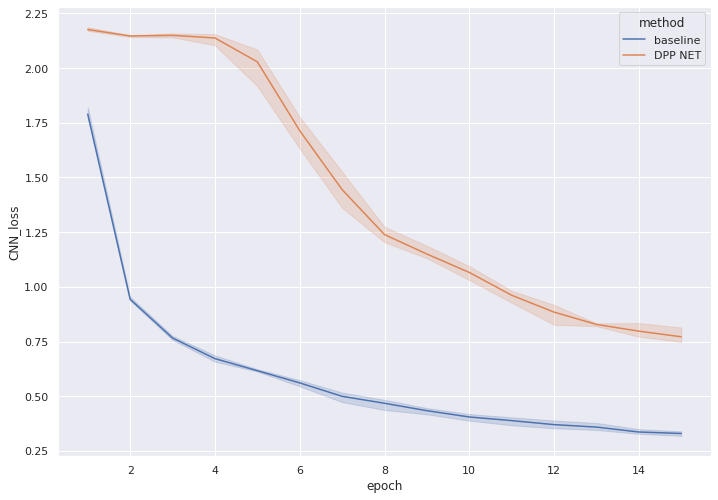

In [ ]:
import seaborn as sns
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="epoch", y= "CNN_loss", hue = "method", data = train_historial)

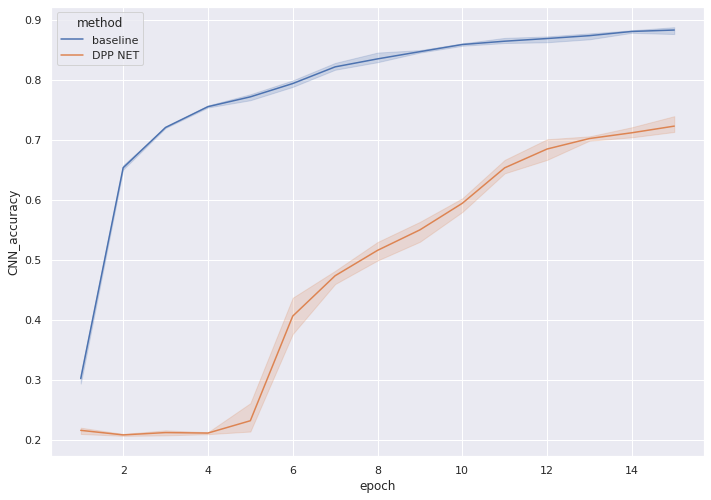

In [ ]:
import seaborn as sns
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="epoch", y= "CNN_accuracy", hue = "method", data = train_historial)

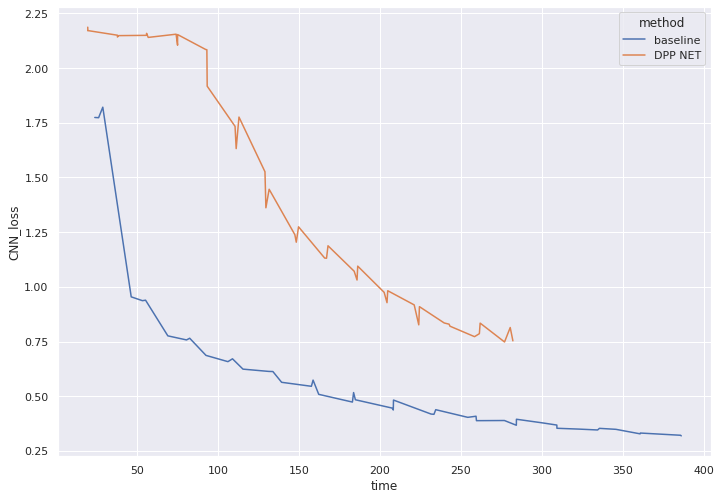

In [ ]:
import seaborn as sns
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", y= "CNN_loss", hue = "method", data = train_historial)

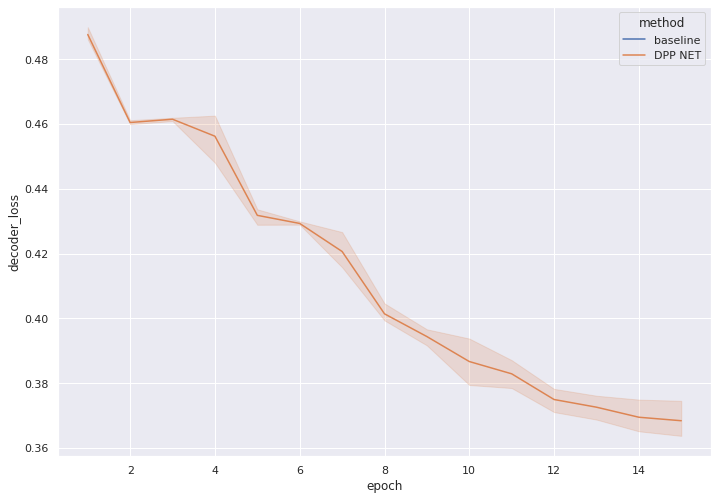

In [ ]:
import seaborn as sns
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="epoch", y= "decoder_loss", hue = "method", data = train_historial)

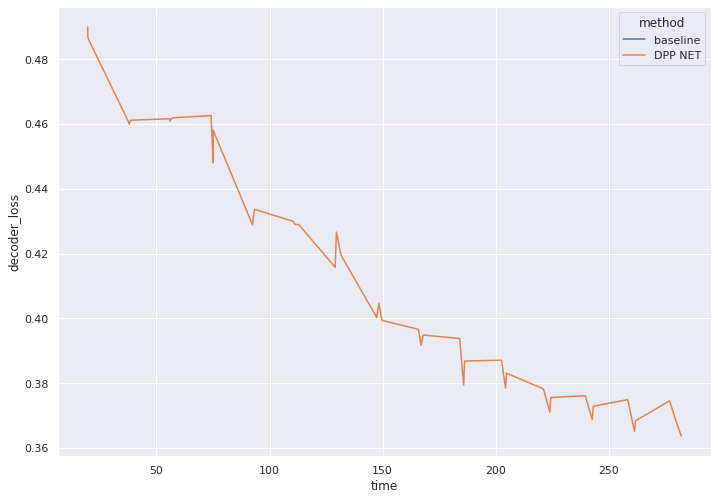

In [ ]:
import seaborn as sns
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", y= "decoder_loss", hue = "method", data = train_historial)

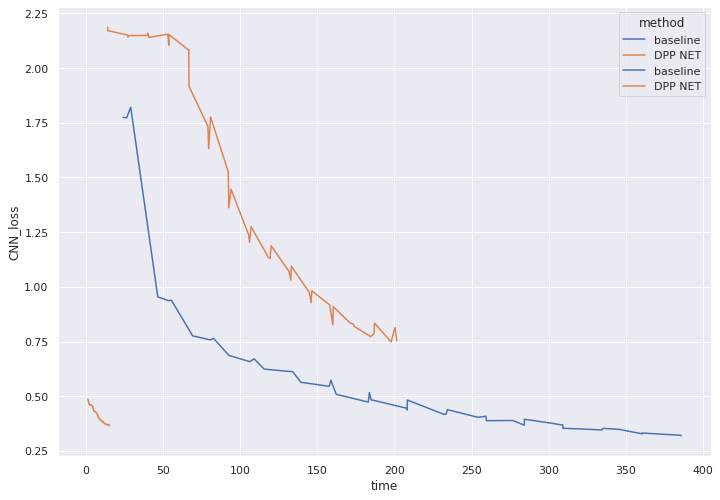

In [ ]:
#Plotting
train_historial_normalized = train_historial.copy()
train_historial_normalized.loc[train_historial_normalized.method == "DPP NET" , "time"] = train_historial_normalized.loc[train_historial_normalized.method == "DPP NET" , "time"] / 1.4
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", y= "CNN_loss", hue = "method", data = train_historial_normalized)
